In [2]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time

In [3]:
# Read in file
filename = "/datax/scratch/nstieg/25GHz_higher.pkl"
df = pd.read_pickle(filename)
# df = df[0:99999] # Just deal with first 100k elements of big file

In [4]:
# See how many rows and columns the df has
print(df.shape)
num_rows = df.shape[0]
num_cols = df.shape[1]

(31208910, 29)


In [5]:
# Look at what's in the file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31208910 entries, 0 to 31208909
Data columns (total 29 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   id                       int64  
 1   beam_id                  int64  
 2   observation_id           int64  
 3   tuning                   object 
 4   subband_offset           int64  
 5   file_uri                 object 
 6   file_local_enumeration   int64  
 7   signal_frequency         float64
 8   signal_index             int64  
 9   signal_drift_steps       int64  
 10  signal_drift_rate        float64
 11  signal_snr               float64
 12  signal_coarse_channel    int64  
 13  signal_beam              int64  
 14  signal_num_timesteps     int64  
 15  signal_power             float64
 16  signal_incoherent_power  float64
 17  source_name              object 
 18  fch1_mhz                 float64
 19  foff_mhz                 float64
 20  tstart                   float64
 21  tsamp 

In [6]:
# Look at the top rows of the frame
df.head()

,id,beam_id,observation_id,tuning,subband_offset,file_uri,file_local_enumeration,signal_frequency,signal_index,signal_drift_steps,...,foff_mhz,tstart,tsamp,ra_hours,dec_degrees,telescope_id,num_timesteps,num_channels,coarse_channel,start_channel
0,900273190,455656,13232,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,0,43255.905447,282420,-205,...,0.000002,60212.560625,0.524288,6.789733,3.27776,0,16,284,0,282175
1,900273191,455656,13232,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,1,43255.657110,152220,-1,...,0.000002,60212.560625,0.524288,6.789733,3.27776,0,16,80,0,152179
2,900273192,455656,13232,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,2,43255.689897,169410,0,...,0.000002,60212.560625,0.524288,6.789733,3.27776,0,16,79,0,169370
3,900273193,455656,13232,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,3,43256.360752,521131,0,...,0.000002,60212.560625,0.524288,6.789733,3.27776,0,16,79,0,521091
4,900273194,455656,13232,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,4,43256.302645,490666,0,...,0.000002,60212.560625,0.524288,6.789733,3.27776,0,16,79,0,490626


In [7]:
# Look at how many unique sources we look at
df["source_name"].unique()
# Incoherent is an incoherent beam observation
# PHASE_CENTER is a pointing with no source we want to observe
# The telephone number is a GAIA ID

array(['3127348761205770496', 'Incoherent', 'PHASE_CENTER',
       '3113493127988068096', '3113482167231459200',
       '3113490855946843904', '3113491272562268160',
       '3074407546904630144', '2542485953354555264',
       '2536546185381558272', '3073619025268414208',
       '2646431411821304960', '3079227054261900160',
       '2535280716217508992', '2557518579407455104'], dtype=object)

In [8]:
# So there were 15 total, of which 2 were Incoherent or PHASE_CENTER
# So there were 13 targets in these beams that actually got observed - for over 4 months of observing that seems super low

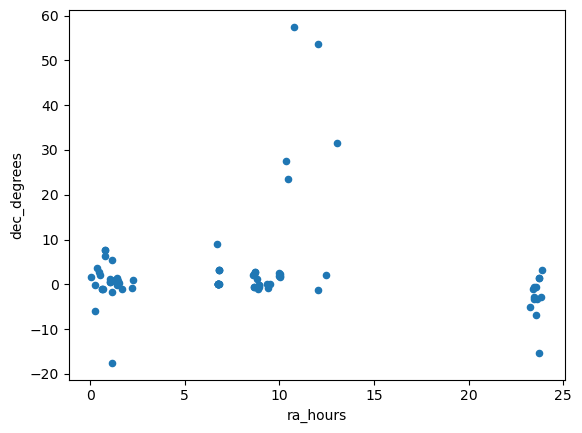

166 unique pointing locations


In [9]:
# Plot the positions of observations on the sky
unique_positions = df[['ra_hours', 'dec_degrees']].drop_duplicates()
unique_positions.plot.scatter("ra_hours", "dec_degrees")
plt.show()
print(f"{unique_positions.size} unique pointing locations")

In [10]:
# Look at how many incoherent, coherent, and phase_center sources we have
incoherent = df["source_name"] == "Incoherent"
tot_incoherent = incoherent.sum()
print("Incoherent:", tot_incoherent)
phase_center = df["source_name"] == "PHASE_CENTER"
tot_phase_center = phase_center.sum()
print("PHASE_CENTER:", tot_phase_center)
coherent = (df["source_name"] != "PHASE_CENTER") & (df["source_name"] != "Incoherent")
tot_coherent = coherent.sum()
print("all coherent:", tot_coherent)
print("Total:", tot_coherent + tot_phase_center + tot_incoherent)
print("Matches:", num_rows)


Incoherent: 6503467
PHASE_CENTER: 21720703
all coherent: 2984740
Total: 31208910
Matches: 31208910


In [11]:
# Get the incoherent points
df_incoherent = df[incoherent]

In [12]:
# Get the coherent points
df_coherent = df[coherent]

In [13]:
# Get the PHASE_CENTER points (coherent not pointed?)
df_phase_center = df[phase_center]

In [14]:
# Check that I understand what beam-id is
# From what I understand, the beam_ids of an observation should be 0-n for n-1 coherent beams and the coherent beam is labeled n
print("all", df["signal_beam"].unique())
print("incoherent", df_incoherent["signal_beam"].unique())
print("coherent", df_coherent["signal_beam"].unique())

all [0 1 2]
incoherent [1 2]
coherent [0 1]


In [15]:
# Seeing only 0 and 1 for the coherent beam means that each observation had either 1 or 2 coherent beams
# The observations with 1 coherent beam had the incoherent beam labeled 1 and those with 2 had it labeled 2

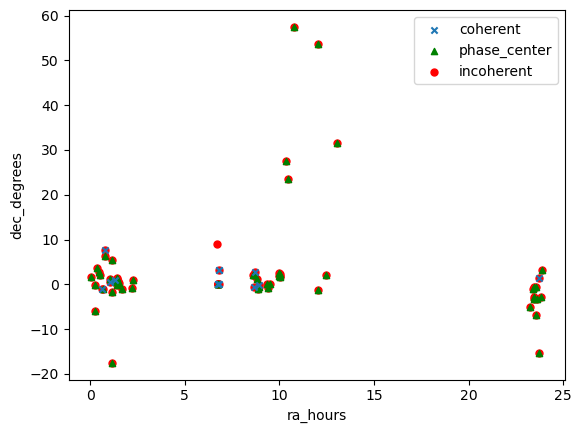

In [16]:
# Plot positions of unique coherent and incoherent sources
# Plot the positions of observations on the sky
coherent_unique_positions = df_coherent[['ra_hours', 'dec_degrees']].drop_duplicates()
ax1 = coherent_unique_positions.plot.scatter("ra_hours", "dec_degrees", marker='x', label="coherent")
phase_center_unique_positions = df_phase_center[['ra_hours', 'dec_degrees']].drop_duplicates()
phase_center_unique_positions.plot.scatter("ra_hours", "dec_degrees", color="green", ax=ax1, zorder=0, label="phase_center", marker="^")
incoherent_unique_positions = df_incoherent[['ra_hours', 'dec_degrees']].drop_duplicates()
incoherent_unique_positions.plot.scatter("ra_hours", "dec_degrees", color="red", ax=ax1, zorder=-1, label="incoherent", s=25)
plt.legend()
plt.show()

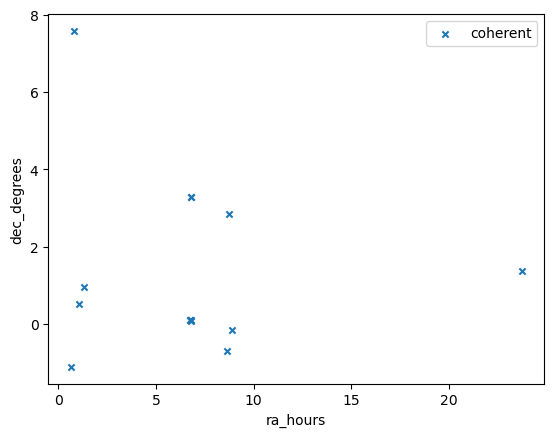

In [17]:
# Plot just the coherent target observations
ax1 = coherent_unique_positions.plot.scatter("ra_hours", "dec_degrees", marker='x', label="coherent")
plt.legend()
plt.show()

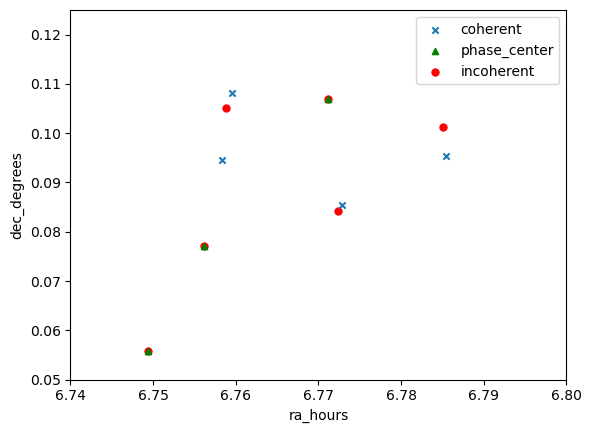

In [75]:
# Plot positions of unique coherent and incoherent sources
# Plot the positions of observations on the sky
# coherent_unique_positions = df_coherent[['ra_hours', 'dec_degrees']].drop_duplicates()
ax1 = coherent_unique_positions.plot.scatter("ra_hours", "dec_degrees", marker='x', label="coherent")
# phase_center_unique_positions = df_phase_center[['ra_hours', 'dec_degrees']].drop_duplicates()
phase_center_unique_positions.plot.scatter("ra_hours", "dec_degrees", color="green", ax=ax1, zorder=0, label="phase_center", marker="^")
# incoherent_unique_positions = df_incoherent[['ra_hours', 'dec_degrees']].drop_duplicates()
incoherent_unique_positions.plot.scatter("ra_hours", "dec_degrees", color="red", ax=ax1, zorder=-1, label="incoherent", s=25)
plt.legend()

# zoom in and look for differences b/w coherent/incoherent pos
plt.xlim([6.74, 6.80]) 
plt.ylim([0.05, 0.125])
plt.show()

In [ ]:
# Could try to visualize how big the coherent/incoherent beams are 
# by plotting them ast plt.circle()'s and using the equation for
# beam size at a given wavelength (have to look up config)
# maybe theta = lambda/D? <- maybe found in NRAO tutorials

In [18]:
# Check how many unique pointings there were
print(coherent_unique_positions.shape[0], "unique coherent pointings")
print(phase_center_unique_positions.shape[0], "unique phase center pointings")
print(incoherent_unique_positions.shape[0], "unique incoherent pointings")

14 unique coherent pointings
56 unique phase center pointings
69 unique incoherent pointings


In [19]:
# This kind of makes sense because a lot of the incoherent pointings are clustered, so maybe the target finding algorithm just kept going to the same coherent points?
# Or maybe is there an incoherent beam every time there's a PHASE_CENTER coherent beam?

In [20]:
# Save the human readable times
df["tstart_h"] = Time(df["tstart"], format="mjd").datetime

25400816 Unique hits at unique times


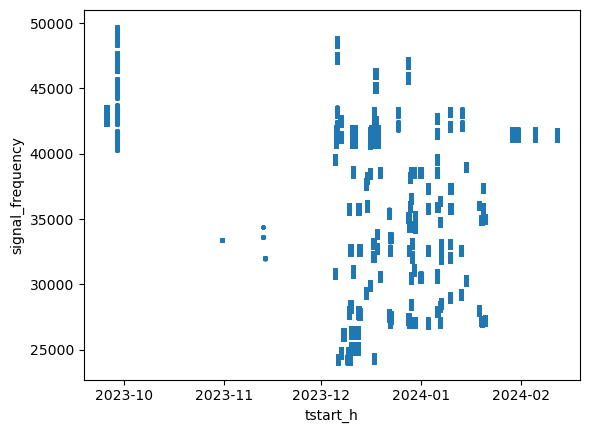

In [21]:
# Look at when signals were found and in what frequency
observations_over_time = df[['tstart_h', 'signal_frequency']].drop_duplicates()
observations_over_time.plot.scatter("tstart_h", "signal_frequency", marker=".")
print(observations_over_time.shape[0], "Unique hits at unique times")

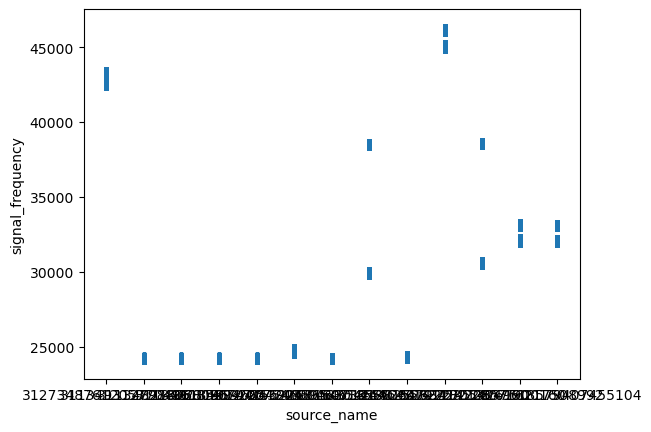

In [78]:
# Plot what frequencies were observed for each target in the coherent beams
df_coherent.plot.scatter("source_name", "signal_frequency", marker=".")
plt.show()

In [ ]:
# It's a little bit of a mess, but it looks like there are
# some common frequencies, especially down by 25GHz
# Let's look at frequencies by source and also maybe
# do the same plot but just for smaller sections of the spectrum

In [ ]:
# Looking at frequencies for each source
for name in df_coherent["source_name"].unique():
    frequencies_at_name = df_coherent[df_coherent["source_name"] == name]
    frequencies_at_name.plot.scatter("tstart_h", "signal_frequency")

In [22]:
# Try to group observations by when they were taken
by_day = df.groupby("tstart")
by_day.first()

,id,beam_id,observation_id,tuning,subband_offset,file_uri,file_local_enumeration,signal_frequency,signal_index,signal_drift_steps,...,foff_mhz,tsamp,ra_hours,dec_degrees,telescope_id,num_timesteps,num_channels,coarse_channel,start_channel,tstart_h
tstart,,,,,,,,,,,,,,,,,,,,,
60212.560625,900273190,455656,13232,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,0,43255.905447,282420,-205,...,0.000002,0.524288,6.789733,3.277760,0,16,284,0,282175,2023-09-25 13:27:17.970905
60212.560661,1034389802,493908,13232,AC,864,/mnt/cosmic-storage-1/data1/batch_processed/23...,0,43415.687539,42043,0,...,0.000008,0.131072,6.789716,3.277763,0,64,79,0,42003,2023-09-25 13:27:21.116694
60212.560758,1034389794,493906,13232,AC,864,/mnt/cosmic-storage-1/data1/batch_processed/23...,0,43415.687539,42043,0,...,0.000008,0.131072,6.789716,3.277763,0,64,79,0,42003,2023-09-25 13:27:29.505262
60212.560855,1034389810,493910,13232,AC,864,/mnt/cosmic-storage-1/data1/batch_processed/23...,0,43415.687539,42043,0,...,0.000008,0.131072,6.789716,3.277763,0,64,79,0,42003,2023-09-25 13:27:37.893790
60212.562064,900276367,455664,13233,AC,704,/mnt/cosmic-storage-2/data1/vla_target/23A-362...,0,43255.712948,181495,-1,...,0.000002,0.524288,6.789733,3.277760,0,16,80,0,181454,2023-09-25 13:29:22.355384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60352.298131,1057339015,508471,19940,AC,736,/mnt/cosmic-storage-2/data3/vla_target/24A-391...,0,41633.148220,182567,-1,...,0.000002,0.524288,10.020139,2.314644,0,16,80,0,182526,2024-02-12 07:09:18.488891
60352.308737,1057341045,508473,19943,AC,480,/mnt/cosmic-storage-2/data3/vla_target/24A-391...,0,41377.096161,155273,0,...,0.000002,0.524288,10.020139,2.314644,0,16,79,0,155233,2024-02-12 07:24:34.887018
60352.310841,1057343074,508475,19944,AC,736,/mnt/cosmic-storage-2/data3/vla_target/24A-391...,0,41633.314947,269980,-33,...,0.000002,0.524288,10.020139,2.314644,0,16,112,0,269907,2024-02-12 07:27:36.628981


In [23]:
# So there are 4703 unique observation times

In [24]:
# So Look at all the hits from a single observation and what beam it's from
first_observation_time = df["tstart"][0]
first_observation_time_h = df["tstart_h"][0]
second_observation_time_h = df["tstart_h"].unique()[1]

print(f"first observation from: {first_observation_time_h}")
print(f"second observation from {second_observation_time_h}")
first_group = by_day.get_group(first_observation_time)
first_group["signal_beam"]

first observation from: 2023-09-25 13:27:17.970905
second observation from 2023-09-25T13:29:22.355384000


0       0
1       0
2       0
3       0
4       0
       ..
3172    1
3173    1
3174    1
3175    1
3176    1
Name: signal_beam, Length: 3177, dtype: int64

In [25]:
# Was this a phase_center or was there one real target in the beam?
first_group["source_name"].unique()
first_group_coherent_target = first_group["source_name"].unique()[0]
print(first_group_coherent_target)

3127348761205770496


In [26]:
# So there was a real target and an incoherent beam

In [27]:
# See how many were coherent/incoherent hits
first_group_coherent_indices = first_group["signal_beam"] == 0
first_group_incoherent_indices = first_group["signal_beam"] == 1
print(first_group_coherent_indices.sum(), "coherent")
print(first_group_incoherent_indices.sum(), "incoherent")

1800 coherent
1377 incoherent


In [28]:
# Could there be multiple hits per beam per FOV?
# I guess I'd assume that this is 3k+ different frequencies within the same exposures
# Let's test this hypothesis
first_group_coherent = first_group[first_group_coherent_indices]
first_group_incoherent = first_group[first_group_incoherent_indices]

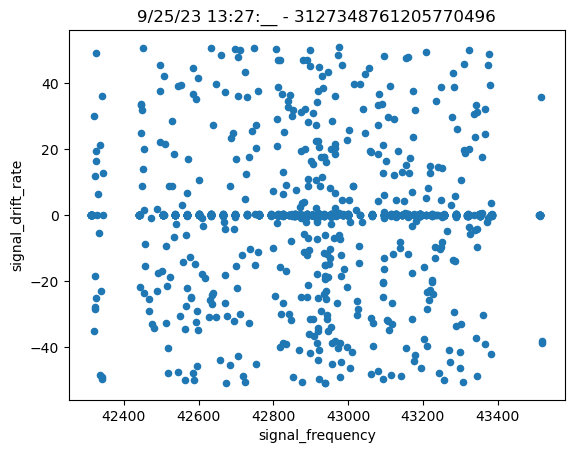

In [29]:
# drift rate vs. f
first_group_coherent.plot.scatter("signal_frequency", "signal_drift_rate")
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.show()

# # drift steps vs. f (matches drift rate)
# first_group_coherent.plot.scatter("signal_frequency", "signal_drift_steps")
# plt.show()


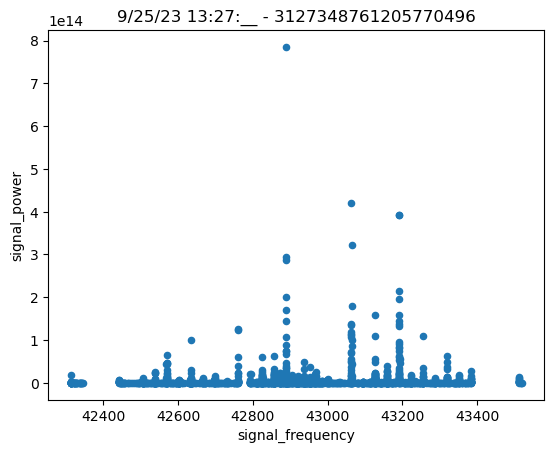

In [30]:
# power vs. f
first_group_coherent.plot.scatter("signal_frequency", "signal_power")
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.show()

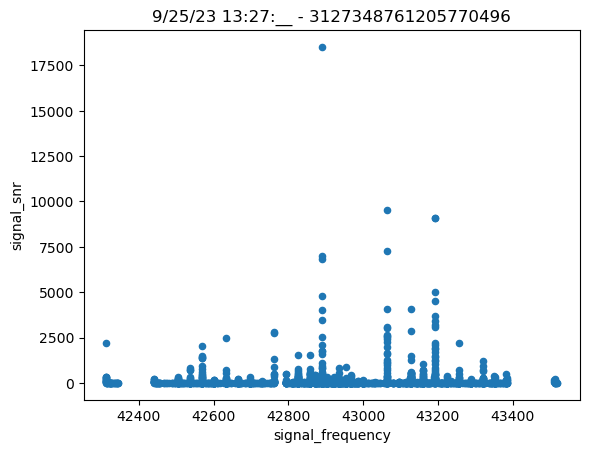

In [31]:
# snr vs. f
first_group_coherent.plot.scatter("signal_frequency", "signal_snr")
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.show()

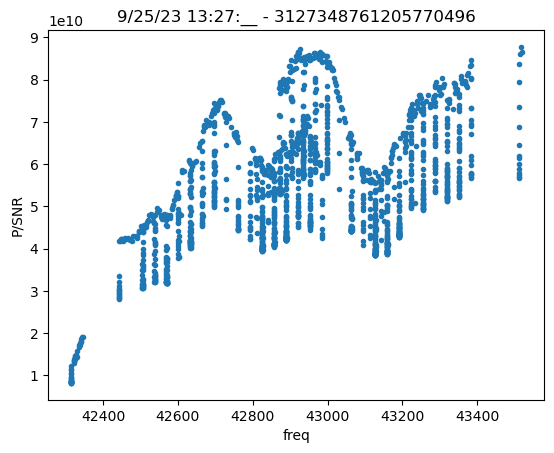

In [32]:
# look at power / SNR ratio
xaxis = first_group_coherent["signal_frequency"]
yaxis = first_group_coherent["signal_power"] / first_group_coherent["signal_snr"]
plt.scatter(xaxis, yaxis, marker=".")
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.xlabel("freq")
plt.ylabel("P/SNR")
plt.show()

In [33]:
# # Look at signal_num_timesteps - all the same?
# first_group_coherent.plot.scatter("signal_frequency", "signal_num_timesteps")
# plt.show()

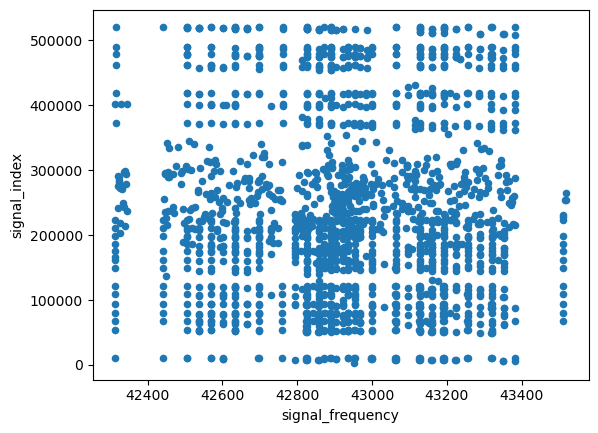

In [34]:
# Look at signal_index - internal number of database?
first_group_coherent.plot.scatter("signal_frequency", "signal_index")
plt.show()

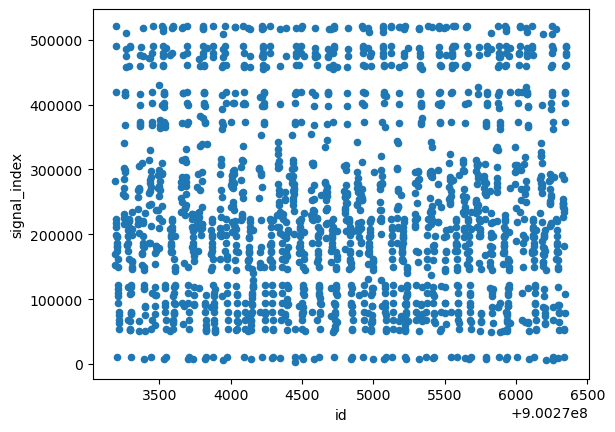

In [35]:
# Look at signal_index - internal number of database?
first_group_coherent.plot.scatter("id", "signal_index")
plt.show()

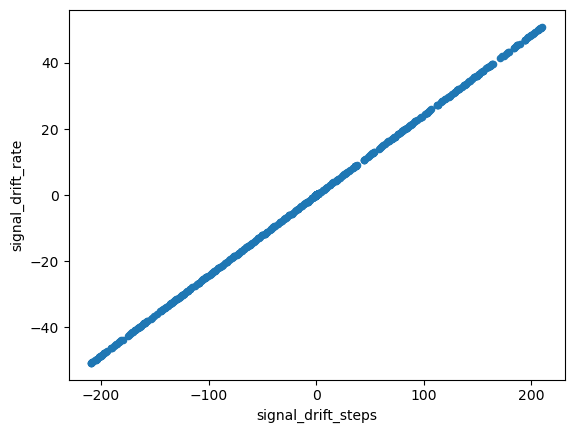

In [60]:
# Look at signal_drift_rate vs. signal_drift_steps
first_group_coherent.plot.scatter("signal_drift_steps", "signal_drift_rate")
plt.show()

In [36]:
# # drift rate vs. signal_coarse_channel - there's some modulo relationship here (32 coarse channels or something)
# first_group_coherent.plot.scatter("signal_frequency", "signal_coarse_channel")
# plt.show()

# # So this is showing the 1 MHz wide coarse channels (note 42800 in the signal_frequency is units of MHz, 42.8GHz)
# # I guess they get modded into 32-wide groups

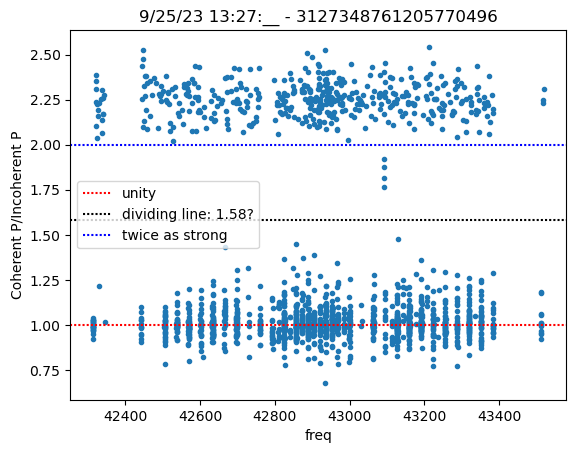

In [37]:
# look at coherent power / incoherent power
# Bimodal distribution?
xaxis = first_group_coherent["signal_frequency"]
yaxis = first_group_coherent["signal_power"] / first_group_coherent["signal_incoherent_power"]
plt.scatter(xaxis, yaxis, marker=".")

# titles
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.xlabel("freq")
plt.ylabel("Coherent P/Incoherent P")

# horizontal lines
plt.axhline(1, dashes=[1, 1, 1, 1], color="red", label="unity") # signal should be stronger than seen in incoherent beam?
divide = 1.58 # What line divides the bimodal distribution?
plt.axhline(divide, dashes=[1, 1, 1, 1], color="black", label=f"dividing line: {divide}?")
plt.axhline(2, dashes=[1, 1, 1, 1], color="blue", label="twice as strong")

plt.legend()
plt.show()


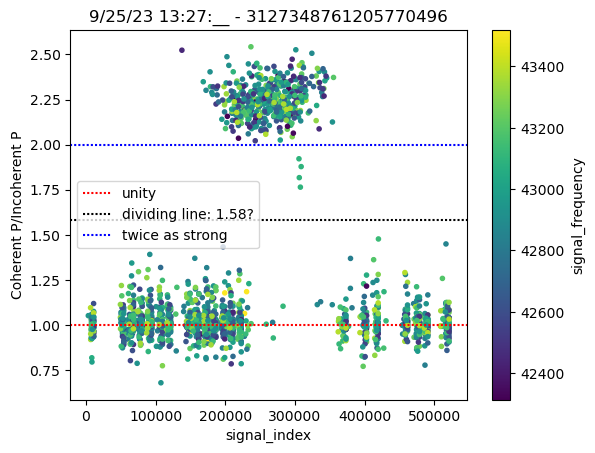

In [55]:
# Coherent power /Incoherent Power but with index as xaxis
# Why is the middle different?
xaxis = first_group_coherent["signal_index"]
yaxis = first_group_coherent["signal_power"] / first_group_coherent["signal_incoherent_power"]
color_by = "signal_frequency"
colors = first_group_coherent[color_by]
plt.scatter(xaxis, yaxis, marker='.', c=colors)

# Colorbar
cbar = plt.colorbar()
cbar.set_label(color_by, rotation=90, labelpad=5)

# labels
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.xlabel("signal_index")
plt.ylabel("Coherent P/Incoherent P")

# horizontal lines
plt.axhline(1, dashes=[1, 1, 1, 1], color="red", label="unity") # signal should be stronger than seen in incoherent beam?
divide = 1.58 # What line divides the bimodal distribution?
plt.axhline(divide, dashes=[1, 1, 1, 1], color="black", label=f"dividing line: {divide}?")
plt.axhline(2, dashes=[1, 1, 1, 1], color="blue", label="twice as strong")

plt.legend()
plt.show()

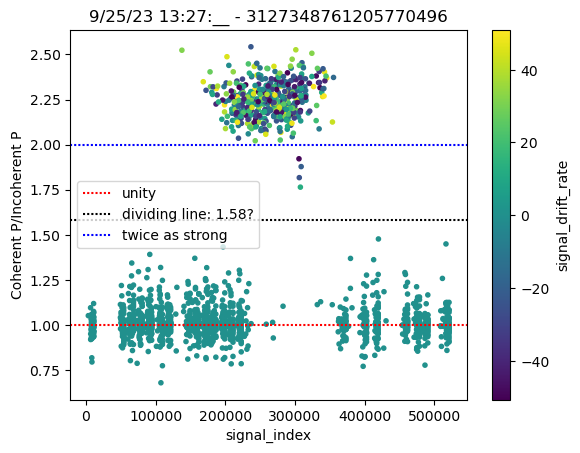

In [59]:
# Coherent power /Incoherent Power but with index as xaxis
# Why is the middle different?
xaxis = first_group_coherent["signal_index"]
yaxis = first_group_coherent["signal_power"] / first_group_coherent["signal_incoherent_power"]
color_by = "signal_drift_rate"
colors = first_group_coherent[color_by]
plt.scatter(xaxis, yaxis, marker='.', c=colors)

# Colorbar
cbar = plt.colorbar()
cbar.set_label(color_by, rotation=90, labelpad=5)

# labels
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.xlabel("signal_index")
plt.ylabel("Coherent P/Incoherent P")

# horizontal lines
plt.axhline(1, dashes=[1, 1, 1, 1], color="red", label="unity") # signal should be stronger than seen in incoherent beam?
divide = 1.58 # What line divides the bimodal distribution?
plt.axhline(divide, dashes=[1, 1, 1, 1], color="black", label=f"dividing line: {divide}?")
plt.axhline(2, dashes=[1, 1, 1, 1], color="blue", label="twice as strong")

plt.legend()
plt.show()

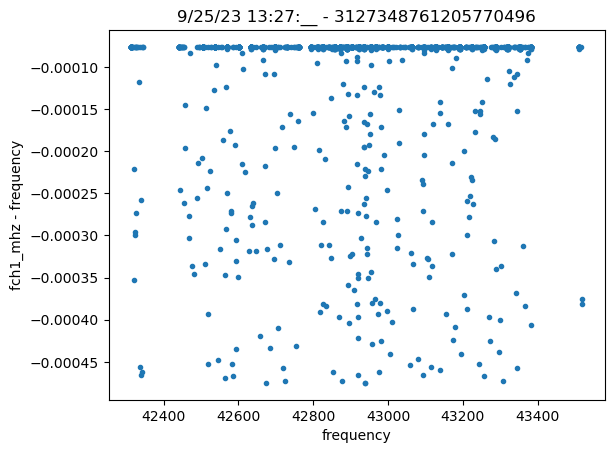

In [40]:
# How are signal_frequency and fch1_mhz related?
# first_group_coherent.plot.scatter("signal_frequency", "fch1_mhz")
xaxis = first_group_coherent["signal_frequency"]
yaxis = first_group_coherent["fch1_mhz"] - first_group_coherent["signal_frequency"]
plt.scatter(xaxis, yaxis, marker=".")

# labels
plt.title(f"9/25/23 13:27:__ - {first_group_coherent_target}")
plt.xlabel("frequency")
plt.ylabel("fch1_mhz - frequency")


plt.show()

# fch1_mhz is the coarse channel (1MHz from COSMIC, 32 per compute node). Is it the edge or the center of the 1 MHz coarse channel bin
# 

In [41]:
# Look at what beam_id is - for some reason it's not the same across beams? alternates?
print(first_group_incoherent["beam_id"].unique())
print(first_group_coherent["beam_id"].unique())

[455657 455659 455661 455663]
[455656 455658 455660 455662]


In [63]:
# Investigate one column of the df
# key = "signal_num_timesteps"
# uniques = df[key].unique()
# print(f"There are {uniques.shape[0]} unique values for {key}:")
# print(uniques)

There are 4 unique values for signal_num_timesteps:
[16  8  4 64]


In [43]:
# Group by the time the observation started and what the beam was
# gdf = df.groupby(["tstart", "signal_beam"])
# gdf.first() # Look at all the first hits from tstart x and beam y
# gdf.get_group((df["tstart"][0], 0)) # Look at all the hits from tstart _first_ and beam 0

In [44]:
# # Look to see if the SIMBAD database and the GAIA match up
# print(df[["ra_hours", "dec_degrees"]].iloc[0])
# df["source_name"][0]